# MinMod Knowledge Graph

### live at [https://minmod.isi.edu/](https://minmod.isi.edu/) wrapping a [SPARQL Endpoint](https://minmod.isi.edu/sparql).

MinMod is the mineral data **Knowledge Graph (KG)**, integrating heterogeneous data sources including: grade-tonnage data extracted from **mine reports**, **scholarly articles**, **mine site databases**, and **structured tables** to provide a rich, queryable graph of mineral site information, and **links** to additional knowledge bases such as [GeoKB](https://geokb.wikibase.cloud/).

### data in this knowledge graph adhere to this [schema](https://github.com/DARPA-CRITICALMAAS/schemas/blob/main/ta2/README.md).

## Why KGs?

<img src="demo_imgs/minmod_kg.png" alt="minmod kg" width="250"/>

- KGs
  - graphs are natural way to **encode data**
  - KGs use **semantic concepts & relationships** to create a **Semantic Network**
  - involves **spatial & temporal** information
- RDF
  - framework within the **Semantic Web** stack
  - an extension of WWW, enabling the Web of Data (aka **"Linked Data"**)
  - Linked Open Data & **FAIR** data principles

## Constructing the KG

- Extracted data --> `JSON-LD` readers / `TTL` triples reader
- Predefined data
  - Open set of commodity entities (based on MRDS/GeoKB)
  - Finite set of deposit type entities
  - Ontology following schema to enforce class & property constraints

<img src="demo_imgs/minmod_pipeline.png" alt="minmod kg" width="600"/>

## Interacting with the KG
MinMod KG `SPARQL` Sandbox

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
def run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=False):
    # add prefixes
    final_query = '''
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX : <https://minmod.isi.edu/resource/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX gkbi: <https://geokb.wikibase.cloud/entity/>
    PREFIX gkbp: <https://geokb.wikibase.cloud/wiki/Property:>
    PREFIX gkbt: <https://geokb.wikibase.cloud/prop/direct/>
    \n''' + query
    # send query
    response = requests.post(
        url=endpoint,
        data={'query': final_query},
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/sparql-results+json"  # Requesting JSON format
        },
        verify=False  # Set to False to bypass SSL verification as per the '-k' in curl
    )
    #print(response.text)
    try:
        qres = response.json()
        if "results" in qres and "bindings" in qres["results"]:
            df = pd.json_normalize(qres['results']['bindings'])
            if values:
                filtered_columns = df.filter(like='.value').columns
                df = df[filtered_columns]
            return df
    except:
        return None

In [3]:
def run_minmod_query(query, values=False):
    return run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=values)

def run_geokb_query(query, values=False):
    return run_sparql_query(query, endpoint='https://geokb.wikibase.cloud/query/sparql', values=values)

--------------------------------------------------------

### 0. Count total number of triples in KG

In [4]:
query = ''' SELECT (COUNT(?s) as ?count)
            WHERE {
                ?s ?p ?o .
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,1674


### 1. Deposit Types

In [5]:
query = ''' SELECT ?ci ?cn
            WHERE {
                ?ci a :DepositType .
                ?ci :name ?cn .
            } '''
run_minmod_query(query)

,ci.type,ci.value,cn.type,cn.value
0,uri,https://minmod.isi.edu/resource/Q4,literal,Sedex Type Deposits
1,uri,https://minmod.isi.edu/resource/Q24,literal,MVT zinc-lead


### 2. Mineral Inventories

#### 2.1. all **inferred** ore values, from all inventories, their grades, cutoff grades, & dates

In [6]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade ?cutoff_grade ?date
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category :Inferred .
                ?o_inv :commodity [ :name ?comm_name ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
                ?o_inv :date ?date .
            } '''
run_minmod_query(query, values=True)

,o_inv.value,comm_name.value,ore.value,grade.value,cutoff_grade.value,date.value
0,https://minmod.isi.edu/resource/Q114,Zinc,2276600,13.37,6,09-19-2017


#### 2.2. all mineral inventories with **inferred** values and grade >= 14

In [7]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category :Inferred .
                ?o_inv :commodity [ :name ?comm_name ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                FILTER (?grade >= 14)
            } '''
run_minmod_query(query, values=True)

,o_inv.value,comm_name.value,ore.value,grade.value
0,https://minmod.isi.edu/resource/Q104012,Zinc,1970400,14.36
1,https://minmod.isi.edu/resource/Q10404,Zinc,1499200,16.02
2,https://minmod.isi.edu/resource/Q10408,Zinc,1772600,15.01


### 3. Commodities

#### 3.1. all commodities and their `GeoKB` URIs

In [8]:
query = ''' SELECT ?ci ?cn ?gi
            WHERE {
                ?ci a :Commodity .
                ?ci :name ?cn .
                ?ci owl:sameAs ?gi .
            } '''
example_df = run_minmod_query(query)
example_df

,ci.type,ci.value,cn.type,cn.xml:lang,cn.value,gi.type,gi.value
0,uri,https://minmod.isi.edu/resource/Q563,literal,en,"Iron, Pyrite",uri,https://geokb.wikibase.cloud/entity/Q448
1,uri,https://minmod.isi.edu/resource/Q515,literal,en,Boron-Borates,uri,https://geokb.wikibase.cloud/entity/Q418
2,uri,https://minmod.isi.edu/resource/Q574,literal,en,Mica,uri,https://geokb.wikibase.cloud/entity/Q476
3,uri,https://minmod.isi.edu/resource/Q541,literal,en,Dolomite,uri,https://geokb.wikibase.cloud/entity/Q444
4,uri,https://minmod.isi.edu/resource/Q565,literal,en,Lead,uri,https://geokb.wikibase.cloud/entity/Q342
...,...,...,...,...,...,...,...
84,uri,https://minmod.isi.edu/resource/Q544,literal,en,Gemstone,uri,https://geokb.wikibase.cloud/entity/Q452
85,uri,https://minmod.isi.edu/resource/Q568,literal,en,"Limestone, Ultra Pure",uri,https://geokb.wikibase.cloud/entity/Q471
86,uri,https://minmod.isi.edu/resource/Q535,literal,en,"Coal, Lignite",uri,https://geokb.wikibase.cloud/entity/Q438
87,uri,https://minmod.isi.edu/resource/Q516,literal,en,Cadmium,uri,https://geokb.wikibase.cloud/entity/Q306


#### 3.2. get commodity symboles from `GeoKB`

In [9]:
def get_symbol_via_sparql(geokb_uri):
    query = '''
    SELECT ?symb
    WHERE {
        <%s> gkbt:P17 ?symb .
    }''' % (geokb_uri)
    result_record = run_geokb_query(query)
    if len(result_record) > 0:
        return result_record.iloc[0]['symb.value']
    return ""

In [10]:
pd.set_option('display.max_rows', 500)

example_df['geoKB Symbol'] = example_df['gi.value'].progress_apply(get_symbol_via_sparql)
example_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [01:09<00:00,  1.28it/s]


,ci.type,ci.value,cn.type,cn.xml:lang,cn.value,gi.type,gi.value,geoKB Symbol
0,uri,https://minmod.isi.edu/resource/Q563,literal,en,"Iron, Pyrite",uri,https://geokb.wikibase.cloud/entity/Q448,
1,uri,https://minmod.isi.edu/resource/Q515,literal,en,Boron-Borates,uri,https://geokb.wikibase.cloud/entity/Q418,
2,uri,https://minmod.isi.edu/resource/Q574,literal,en,Mica,uri,https://geokb.wikibase.cloud/entity/Q476,
3,uri,https://minmod.isi.edu/resource/Q541,literal,en,Dolomite,uri,https://geokb.wikibase.cloud/entity/Q444,
4,uri,https://minmod.isi.edu/resource/Q565,literal,en,Lead,uri,https://geokb.wikibase.cloud/entity/Q342,Pb
5,uri,https://minmod.isi.edu/resource/Q555,literal,en,Gypsum-Anhydrite,uri,https://geokb.wikibase.cloud/entity/Q463,
6,uri,https://minmod.isi.edu/resource/Q518,literal,en,Cement Rock,uri,https://geokb.wikibase.cloud/entity/Q420,
7,uri,https://minmod.isi.edu/resource/Q548,literal,en,"Gemstone, Sapphire",uri,https://geokb.wikibase.cloud/entity/Q457,
8,uri,https://minmod.isi.edu/resource/Q587,literal,en,Tin,uri,https://geokb.wikibase.cloud/entity/Q392,Sn
9,uri,https://minmod.isi.edu/resource/Q539,literal,en,"Copper, Oxide",uri,https://geokb.wikibase.cloud/entity/Q441,


------

### 4. Mineral Sites

#### 4.1. all `MineralSite` instances

In [11]:
query = ''' SELECT ?ms ?ms_p ?ms_v
            WHERE {
                ?ms a :MineralSite .
                ?ms ?ms_p ?ms_v .
            } '''
run_minmod_query(query, values=True)

,ms.value,ms_p.value,ms_v.value
0,https://minmod.isi.edu/resource/MineralSite0_1,https://minmod.isi.edu/resource/same_as,https://minmod.isi.edu/resource/SameAs1_1_1
1,https://minmod.isi.edu/resource/MineralSite0_1,https://minmod.isi.edu/resource/same_as,https://minmod.isi.edu/resource/SameAs1_1_0
2,https://minmod.isi.edu/resource/MineralSite0_1,https://minmod.isi.edu/resource/location_info,https://minmod.isi.edu/resource/LocationInfo3_1
3,https://minmod.isi.edu/resource/MineralSite0_1,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,https://minmod.isi.edu/resource/MineralSite
4,https://minmod.isi.edu/resource/MineralSite0_1,https://minmod.isi.edu/resource/mineral_inventory,https://minmod.isi.edu/resource/MineralInvento...
5,https://minmod.isi.edu/resource/MineralSite0_1,https://minmod.isi.edu/resource/name,Reocin Mine
6,https://minmod.isi.edu/resource/MineralSite0_1,https://minmod.isi.edu/resource/deposit_type,https://minmod.isi.edu/resource/DepositType2_1_0
7,https://minmod.isi.edu/resource/MineralSite0_2,https://minmod.isi.edu/resource/same_as,https://minmod.isi.edu/resource/SameAs1_2_2
8,https://minmod.isi.edu/resource/MineralSite0_2,https://minmod.isi.edu/resource/same_as,https://minmod.isi.edu/resource/SameAs1_2_0
9,https://minmod.isi.edu/resource/MineralSite0_2,https://minmod.isi.edu/resource/same_as,https://minmod.isi.edu/resource/SameAs1_2_1


#### 4.2. all `MineralSite` URIs with Deposit Type `Sedex Type Deposits`

In [12]:
query = ''' SELECT ?ms ?ms_p ?ms_v
            WHERE {
                ?ms a :MineralSite .
                ?ms :deposit_type [ :name "Sedex Type Deposits" ] .
            } '''
run_minmod_query(query, values=True)

,ms.value
0,https://minmod.isi.edu/resource/Q0


## 5. Grade-Tonnage models

In [13]:
# todo: ?mineralInventory :date        "%s"#^^xsd:dateTime .
# todo: use grade-units to convert to single unit/format
# todo: use ore-units to convert to single unit/format

query_template = '''
SELECT ?mineralInventory ?tonnage  ?grade ?inventoryName ?category
WHERE {
    ?mineralInventory a            :MineralInventory .
    ?mineralInventory :id          ?inventoryName .

    ?mineralInventory :date        "%s" .
    
    ?mineralInventory :ore         ?ore .
    ?ore              :ore_value   ?tonnage .
    
    ?mineralInventory :grade       ?gradeInfo .
    ?gradeInfo        :grade_value ?grade .
    
    ?mineralInventory :commodity   ?Commodity .
    ?Commodity        :name        "%s"@en .

    ?mineralInventory :category    ?category .
}
'''

In [14]:
# todo: this example is f(timestamp, commodity)

query_resp_df = run_minmod_query(query_template % ('09-19-2017', 'Zinc'), values=True)
mineral_data_df = pd.DataFrame([
    {
        'mineralInventory': row['mineralInventory.value'],
        'name': row['inventoryName.value'],  # This is now the inventory ID/name
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value']#.split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,mineralInventory,name,tonnage,grade,category
0,https://minmod.isi.edu/resource/Q113,Inv003,2158000.0,13.29,https://minmod.isi.edu/resource/Measured
1,https://minmod.isi.edu/resource/Q113,Inv003,2158000.0,13.29,https://minmod.isi.edu/resource/Indicated
2,https://minmod.isi.edu/resource/Q1,Inv001,850100.0,13.19,https://minmod.isi.edu/resource/Measured
3,https://minmod.isi.edu/resource/Q114,Inv004,2276600.0,13.37,https://minmod.isi.edu/resource/Inferred
4,https://minmod.isi.edu/resource/Q112,Inv002,1307900.0,13.35,https://minmod.isi.edu/resource/Indicated


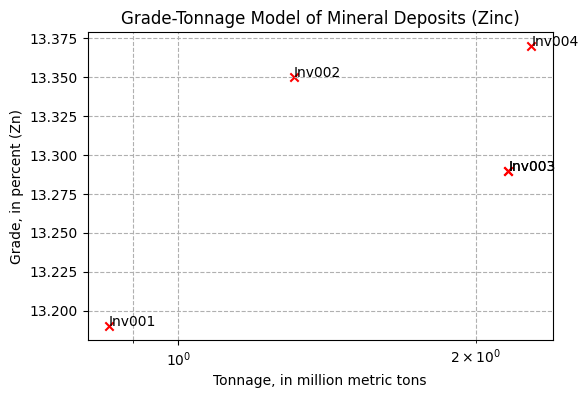

In [15]:
tonnages = mineral_data_df['tonnage'].values
grades = mineral_data_df['grade'].values
names = mineral_data_df['name'].values

# todo: convert tonnage to million metric tons using unit-transformation
tonnages_million_metric_tons = tonnages / 1e6

plt.figure(figsize=(6, 4))
scatter = plt.scatter(tonnages_million_metric_tons, grades, marker='x', color='r')

# loga scale
plt.xscale('log')

# todo: units should be evaluated and converted
plt.xlabel('Tonnage, in million metric tons')
plt.ylabel('Grade, in percent (Zn)')
# todo, commodity name comes from query
plt.title('Grade-Tonnage Model of Mineral Deposits (Zinc)')

plt.grid(True, which="both", ls="--")
for i, txt in enumerate(names):
    plt.annotate(txt, (tonnages_million_metric_tons[i], grades[i]))
plt.show()